<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/Auto-Regressive%20Model/auto_regressive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Auto-regressive model**

A linear model where current period values are a sum of past outcomes multiplied by numeric factors.


## Import packages and libraries


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

## Import the Data


In [2]:
## mount the google drive to fetch the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## load the dataset
raw_csv_data = pd.read_csv('/content/drive/MyDrive/Data Science/Time Series/Index2018.csv')
raw_csv_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
## transforming the dataset
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b') # business days as frequency
df_comp = df_comp.fillna(method='ffill')

In [5]:
df_comp['market_value'] = df_comp.ftse

In [6]:
del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']


## Splitting the Training and Testing Set

In [7]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The ACF

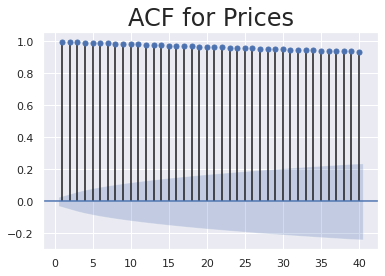

In [8]:
sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title('ACF for Prices', size=24)
plt.show()

The more lags we include, the better model will fit the dataset we feed it.

Coefficients might predict the dataset **"too"** well

Makes the model overfit and prone to mistakes.

## The PACF

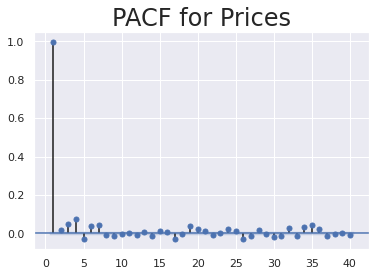

In [11]:
sgt.plot_pacf(df.market_value, zero=False, lags=40, alpha=0.5, method=('ols'))
plt.title('PACF for Prices', size=24)
plt.show()

The above PACF shows coefficients of different size (not all between 0.9 and 1).

Coefficients that are negative.

Coefficients which are not significant.

From 25th to 40th lag coefficient values will be extremely close to zeroes. Their impact on model will be minimal, so they are not relevant to us.

Therefore our model should include lags less than 25.

## The AR(1) model

We are going to pass several parameters to the class of **ARMA** to make it an Auto-Regressive model.

**order** : 1- The number of past values we wish to incorporate into our model.

            0 - Not taking any of the residual values into consideration.

            

In [13]:
model_ar = ARMA(df.market_value, order=(1,0),)

In [14]:
results_ar = model_ar.fit()

In [15]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.598
Method:                       css-mle   S.D. of innovations             59.258
Date:                Mon, 18 Jul 2022   AIC                          55251.196
Time:                        06:00:04   BIC                          55270.760
Sample:                    01-07-1994   HQIC                         55258.052
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5055.8541    485.798     10.407      0.000    4103.707    6008.001
ar.L1.market_value     0.9985      0.001   1298.620      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

Taking a close look into the summary of the model:

**"const" & "ar.L1.market_vale"** are all the variable that the model estimates.

The **coef** column represents the numeric values associated with "c" and phi from the AR model we defined earlier.

The next column **std err** represents how far away, on average, the model's predictions are from true values.

**z** - The assocaited test-statistics for significance.

**p>|z|** - the p-value is zero which concludes that the **phi** and the constant **C*** are significantly different from zero.

The last two columns represents the **critical values** for 95% confidence intervals.


## Higher-lag AR Models


Now we are going to create a more complex model by including more number of lags and then use Log-Likelihood Ratio Test to determine how good the new complex model is.

In [16]:
model_ar_2 = ARMA(df.market_value, order=(2,0),)
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.871
Method:                       css-mle   S.D. of innovations             59.249
Date:                Mon, 18 Jul 2022   AIC                          55251.742
Time:                        06:45:27   BIC                          55277.827
Sample:                    01-07-1994   HQIC                         55260.883
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6412    495.717     10.267      0.000    4118.054    6061.228
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value     0.0171      0.014      1.211      0.226      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -58.4633           +0.0000j           58.4633            0.5000
-----------------------------------------------------------------------------
"""

The **p-value** of ar.L2.market_value is 0.22 greater than 0.05 ( we are using 5% significance level) we can reject the null-hypothesis. This suggests that the coefficient of 2nd lag isn't different from zero. This means that the prices 2 days ago doen't severely affects the price of today. 

In [17]:
model_ar_3 = ARMA(df.market_value, order=(3,0),)
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.871
Method:                       css-mle   S.D. of innovations             59.178
Date:                Mon, 18 Jul 2022   AIC                          55241.742
Time:                        06:52:21   BIC                          55274.349
Sample:                    01-07-1994   HQIC                         55253.168
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    520.379      9.781      0.000    4069.718    6109.565
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value    -0.0309      0.020     -1.563      0.118      -0.070       0.008
ar.L3.market_value     0.0489      0.014      3.466      0.001       0.021       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.1850           -4.5161j            4.5199           -0.2565
AR.3           -0.1850           +4.5161j            4.5199            0.2565
-----------------------------------------------------------------------------
"""

In [18]:
model_ar_4 = ARMA(df.market_value, order=(4,0),)
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.780
Method:                       css-mle   S.D. of innovations             59.023
Date:                Mon, 18 Jul 2022   AIC                          55217.559
Time:                        06:55:31   BIC                          55256.688
Sample:                    01-07-1994   HQIC                         55231.270
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5416.3868    792.830      6.832      0.000    3862.468    6970.305
ar.L1.market_value     0.9770      0.014     69.540      0.000       0.950       1.005
ar.L2.market_value    -0.0286      0.020     -1.455      0.146      -0.067       0.010
ar.L3.market_value    -0.0224      0.020     -1.135      0.256      -0.061       0.016
ar.L4.market_value     0.0728      0.014      5.170      0.000       0.045       0.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2            0.9545           -2.0879j            2.2957           -0.1818
AR.3            0.9545           +2.0879j            2.2957            0.1818
AR.4           -2.6029           -0.0000j            2.6029           -0.5000
-----------------------------------------------------------------------------
"""

In general we like the **Log-Likelihood** to be greater and **AIC**, **BIC**, **HQIC** lower. 

So we perform the **Log-likelihood Ratio** test.

## The LLR test

In [23]:
def llr_test(mod_1, mod_2, df=1):
   """ mod_1, mod_2= models to compare, df=degrees of freedom"""
   L1 = mod_1.fit().llf
   L2 = mod_2.fit().llf ## log likelihood
   LR = (2*(L2-L1)) ## test statistics
   p = chi2.sf(LR, df).round(3) ## p-value
   return p

## Comparing Higher-Lag AR models

In [24]:
llr_test(model_ar_2, model_ar_3)

ValueError: ignored